# **Complaint Detection - Graph Neural Networks**

In [1]:
!pip install diaparser
#!pip install dgl

In [2]:
from diaparser.parsers import Parser
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

from spacy.lang.en import English
nlp = English()


In [3]:
# Dependency Parser
parser = Parser.load('en_ewt-electra')
sent = 'Economic news had very little effect on financial market .'.split(' ')

parsed = parser.predict([sent], prob=True)
print(parsed.sentences[0])

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


1	Economic	_	_	_	_	2	amod	_	_
2	news	_	_	_	_	3	nsubj	_	_
3	had	_	_	_	_	0	root	_	_
4	very	_	_	_	_	5	advmod	_	_
5	little	_	_	_	_	6	amod	_	_
6	effect	_	_	_	_	3	obj	_	_
7	on	_	_	_	_	9	case	_	_
8	financial	_	_	_	_	9	amod	_	_
9	market	_	_	_	_	6	nmod	_	_
10	.	_	_	_	_	3	punct	_	_



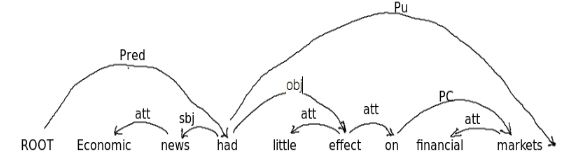

In [4]:
source = parsed.arcs[0]
dest = list(range(1,len(sent)+1))

print('Tweet :', sent)
print(f'Source : {source}\n',
      f'Destination : {dest}\n')

Tweet : ['Economic', 'news', 'had', 'very', 'little', 'effect', 'on', 'financial', 'market', '.']
Source : [2, 3, 0, 5, 6, 3, 9, 9, 6, 3]
 Destination : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]



In [5]:
df = pd.read_csv('/content/drive/MyDrive/Tweets/cd.csv')
df.head(2)

,id,tweet,label,domain
0,2.263108e+16,@FC_HELP can I return online purchases to a Ho...,0,apparel
1,2.336408e+16,@FC_Help Hi - I'm writing a piece for MSN Him ...,0,apparel


In [6]:
#Sample Source and Destination of edges

tweet = nlp(df.tweet[0])
tweet = [tw.text for tw in tweet]
parsed = parser.predict(tweet, prob=True)

source = parsed.arcs[0]
dest = list(range(1,len(tweet)+1))

print('Tweet :', tweet)
print(f'Source : {source}\n',
      f'Destination : {dest}\n')

Tweet : ['@FC_HELP', 'can', 'I', 'return', 'online', 'purchases', 'to', 'a', 'House', 'of', 'Fraser', 'concesssion', 'if', 'I', 'have', 'the', 'delivery', 'note', 'and', 'order', 'details', '?']
Source : [4, 4, 4, 0, 6, 4, 12, 12, 12, 11, 9, 4, 15, 15, 4, 18, 18, 15, 21, 21, 18, 4]
 Destination : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]



In [17]:
#Simple Adjency Matrix 
def adj_matrix(tweet):

  tweet = nlp(tweet)
  tweet = [tw.text for tw in tweet]
  tweet = tweet[:19]
  parsed = parser.predict(tweet, prob=True)

  source = parsed.arcs[0]
  dest = list(range(1,len(tweet)+1))

  A = np.zeros((len(source) + 1, len(dest) + 1))

  for i in range(len(source)):
    A[source[i]][dest[i]] = 1
    A[dest[i]][source[i]] = 1
    A[i][i] = 1

  return A

In [8]:
# import gensim.downloader
# glv = gensim.downloader.load("glove-twitter-200")

In [9]:
import tensorflow_hub as hub
module = hub.load('https://tfhub.dev/tensorflow/cord-19/swivel-128d/3')

2021-03-18 09:37:44 INFO Using /tmp/tfhub_modules to cache modules.


In [10]:
S = []
X = []

# Adjency matric for every tweet
for tweet in df['tweet']:
  tweet += 'dummy ' * (30 - len(nlp(tweet)))
  A = adj_matrix(tweet)
  S.append(A)

# Uppend every sentence with dummy and take first 20 words
for tweet in df['tweet']:
  tweet += 'dummy ' * (30 - len(nlp(tweet)))
  tweet = nlp(tweet)
  tweet = [tw.text for tw in tweet]
  emb = module(tweet)
  X.append(emb[:20])


In [11]:
target = np.array(df['label'])

In [12]:
X_inp = np.stack(X).reshape((len(df), 1, 20, 128))
S_inp = np.stack(S).reshape((len(df), 1, 20, 20))
target = target.reshape((len(df), 1))

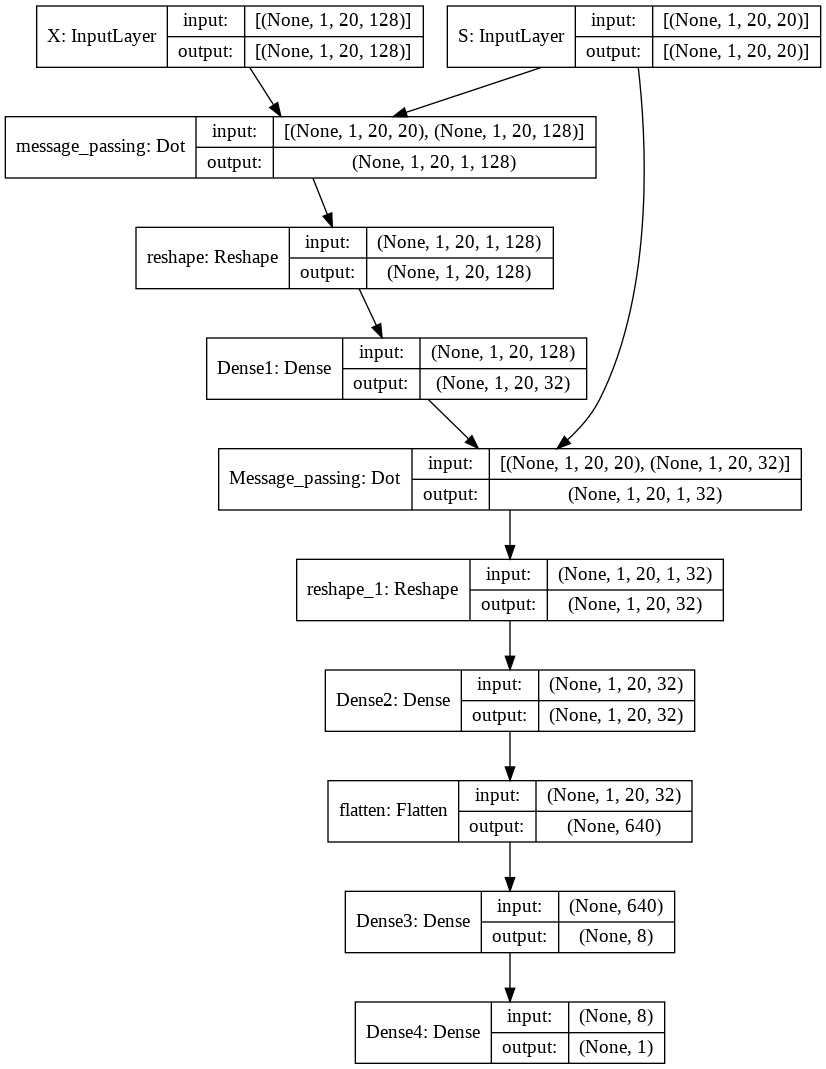

In [13]:
X = keras.Input(shape = (1, 20, 128), name = 'X')
S = keras.Input(shape = (1, 20, 20), name = 'S')

SX = keras.layers.Dot(axes=(2), name = 'message_passing')([S, X])
SX = keras.layers.Reshape((1, 20, 128))(SX)
op1 = tf.keras.layers.Dense(32, activation="relu", name = 'Dense1')(SX)

SSX = keras.layers.Dot(axes=(2), name = 'Message_passing')([S, op1])
SSX = keras.layers.Reshape((1, 20, 32))(SSX)
op2 = tf.keras.layers.Dense(32, activation="relu", name = 'Dense2')(SSX)

flat = tf.keras.layers.Flatten()(op2)
op3 = tf.keras.layers.Dense(8, activation="relu", name = 'Dense3')(flat)
op4 = tf.keras.layers.Dense(1, activation="sigmoid", name = 'Dense4')(op3)

GCN = keras.models.Model([X, S], op4)

plot_model(GCN, show_shapes=True, show_layer_names=True)

In [14]:
GCN.compile(optimizer = 'adam', 
                         loss = 'binary_crossentropy', 
                         metrics = ['binary_accuracy'])

hist = GCN.fit([X_inp, S_inp], target, validation_split = 0.1, batch_size = 256, epochs = 30, verbose = 1)

Epoch 1/30
13/13 [==============================] - 2s 70ms/step - loss: 0.7433 - binary_accuracy: 0.5745 - val_loss: 0.5862 - val_binary_accuracy: 0.6812
Epoch 2/30
13/13 [==============================] - 0s 17ms/step - loss: 0.6111 - binary_accuracy: 0.6468 - val_loss: 0.5725 - val_binary_accuracy: 0.6870
Epoch 3/30
13/13 [==============================] - 0s 17ms/step - loss: 0.6060 - binary_accuracy: 0.6684 - val_loss: 0.5825 - val_binary_accuracy: 0.6754
Epoch 4/30
13/13 [==============================] - 0s 17ms/step - loss: 0.5941 - binary_accuracy: 0.6710 - val_loss: 0.5751 - val_binary_accuracy: 0.6841
Epoch 5/30
13/13 [==============================] - 0s 17ms/step - loss: 0.5800 - binary_accuracy: 0.6921 - val_loss: 0.5800 - val_binary_accuracy: 0.6812
Epoch 6/30
13/13 [==============================] - 0s 19ms/step - loss: 0.5773 - binary_accuracy: 0.6978 - val_loss: 0.5484 - val_binary_accuracy: 0.7333
Epoch 7/30
13/13 [==============================] - 0s 17ms/step - los